In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/dini

/content/drive/MyDrive/dini


In [ ]:
!pwd

/content/drive/MyDrive/dini


## Install bertopic

In [1]:
!pip install bertopic
!pip install umap-learn
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 9.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB

# Preprocessing

In [2]:
import pandas as pd
df = pd.read_csv("detik-fiks.csv")
df_subset = df.head(15020)
#df_subset = df.head(1000) #sukses
df_subset.to_csv("dataset.csv", index=False)

## Case folding

In [3]:
import pandas as pd
df = pd.read_csv('dataset.csv')
df['description_lower_case'] = df['description'].str.lower()
df.to_csv('dataset.csv', index=False)

## Cleaning

In [4]:
import pandas as pd
import string
df = pd.read_csv('dataset.csv')
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
df['description_clean'] = df['description_lower_case'].apply(remove_punctuation)
df.to_csv('dataset.csv', index=False)

In [5]:
import pandas as pd
import spacy
from spacy.lang.id.stop_words import STOP_WORDS

df = pd.read_csv("dataset.csv")
nlp = spacy.blank("id")
def remove_stopwords(text):
    doc = nlp(text)
    filtered_text = [token.text for token in doc if token.text.lower() not in STOP_WORDS]
    return " ".join(filtered_text)
df['description_clean'] = df['description_clean'].apply(remove_stopwords)
df.to_csv("dataset.csv", index=False)


# BERTtopic

In [6]:
import numpy as np
import pandas as pd
train = pd.read_csv('dataset.csv')
train

,title,date,link,description,description_lower_case,description_clean
0,Eks Tim 8 Cerita Sempat Bahas Cak Imin Jadi Ca...,01/09/2023,https://news.detik.com/pemilu/d-6908814/eks-ti...,Soal Cak Imin jadi Cawapres Anies sempat dibah...,soal cak imin jadi cawapres anies sempat dibah...,cak imin cawapres anies dibahas rapat tim 8 de...
1,"Eks Anggota Tim 8: Demokrat Punya Trauma 2018,...",01/09/2023,https://news.detik.com/pemilu/d-6908786/eks-an...,Mantan Anggota Tim 8 KPP Iftitah Sulaiman meng...,mantan anggota tim 8 kpp iftitah sulaiman meng...,mantan anggota tim 8 kpp iftitah sulaiman part...
2,PPP soal Ada Menteri Dorong Koalisi dengan Dem...,01/09/2023,https://news.detik.com/pemilu/d-6908769/ppp-so...,PPP merespons SBY yang menyebut ada menteri ak...,ppp merespons sby yang menyebut ada menteri ak...,ppp merespons sby menyebut menteri aktif menga...
3,"Cak Imin Nyebrang Koalisi, Zulhas: Belok Nggak...",01/09/2023,https://news.detik.com/pemilu/d-6908759/cak-im...,Zulhas menyebut Cak Imin seakan-akan belok tan...,zulhas menyebut cak imin seakan-akan belok tan...,zulhas menyebut cak imin seakanakan belok lamp...
4,Kata Gerindra soal Peluang Demokrat Merapat Du...,01/09/2023,https://news.detik.com/pemilu/d-6908749/kata-g...,Gerindra bicara peluang Demokrat merapat ke Ko...,gerindra bicara peluang demokrat merapat ke ko...,gerindra bicara peluang demokrat merapat koali...
...,...,...,...,...,...,...
15014,Cak Imin Sorot Pemilu di Luar Negeri: Mempriha...,14/02/2024,https://news.detik.com/pemilu/d-7191756/cak-im...,Cak Imin menyoroti proses pencoblosan yang ter...,cak imin menyoroti proses pencoblosan yang ter...,cak imin menyoroti proses pencoblosan negeri c...
15015,Bawaslu Serang Temukan KPPS Bagikan Stiker Cal...,14/02/2024,https://news.detik.com/pemilu/d-7191749/bawasl...,Pelanggaran dilakukan dengan cara memberikan f...,pelanggaran dilakukan dengan cara memberikan f...,pelanggaran formulir c6 pemberitahuan pemungut...
15016,Samawi Gelar Doa Bersama untuk Pemilu 2024: Ag...,14/02/2024,https://news.detik.com/pemilu/d-7191748/samawi...,Samawi menggelar doa bersama untuk kelancaran ...,samawi menggelar doa bersama untuk kelancaran ...,samawi menggelar doa kelancaran pemilu 2024 sa...
15017,Keputusan KPU: Pencoblosan Pemilu 2024 di 4 Di...,14/02/2024,https://news.detik.com/pemilu/d-7191744/keputu...,KPU RI menerbitkan keputusan mengenai pencoblo...,kpu ri menerbitkan keputusan mengenai pencoblo...,kpu ri menerbitkan keputusan pencoblosan pania...


In [7]:
docs = train['description_clean'].to_list()
docs[:100]

['cak imin cawapres anies dibahas rapat tim 8 desember 2022 eks tim 8 menyebut manuver cak imin mengejutkan',
 'mantan anggota tim 8 kpp iftitah sulaiman partai demokrat memiliki trauma pilpres ahy batal diusung cawapres prabowo',
 'ppp merespons sby menyebut menteri aktif mengajak koalisi pd pks ppp menebak',
 'zulhas menyebut cak imin seakanakan belok lampu sein',
 'gerindra bicara peluang demokrat merapat koalisi indonesia maju mendukung prabowo 2024',
 'menurutnya kehadiran anies acara wujud kolaborasi simpul relawan',
 'eks anggota tim 8 mengungkap pkb partai golkar diprediksi masuk koalisi perubahan batal bergabung',
 'demokrat mengambil sikap menyikapi duet anies baswedanketum pkb muhaimin iskandar cak imin demokrat mencabut dukungan anies baswedan capres 2024',
 'sekjen pkb akronim duet aniescak imin amin diharap akronim mengantar aniescak imin menang pilpre',
 'pkb deklarasi aniescak imin besok siang surabaya deklarasi digelar hotel majapahit surabaya besok siang',
 'angela ta

In [8]:
from sentence_transformers import SentenceTransformer
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
embendding = SentenceTransformer("distiluse-base-multilingual-cased-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [9]:
docs_ = embendding.encode(docs)
docs_ = umap_model.fit_transform(docs_)

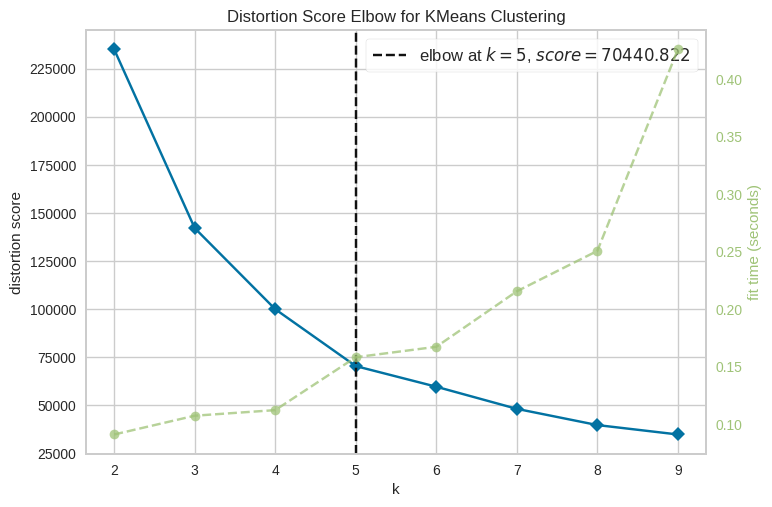

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer

model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion')
visualizer.fit(docs_)
visualizer.show()

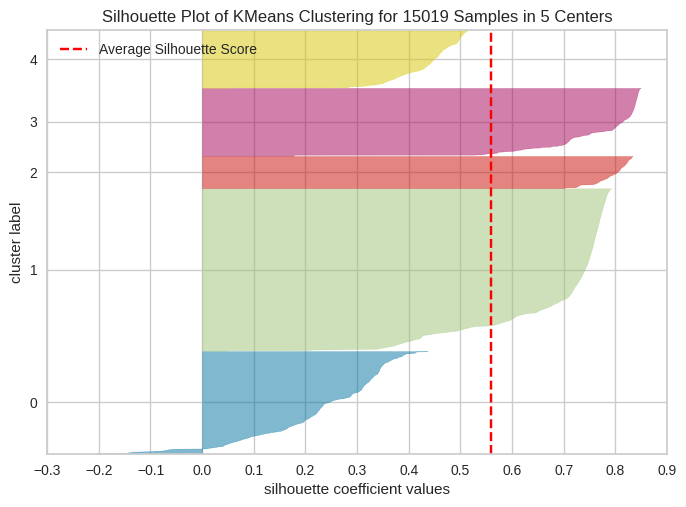

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15019 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [65]:
kmeans = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(docs_)
visualizer.show()

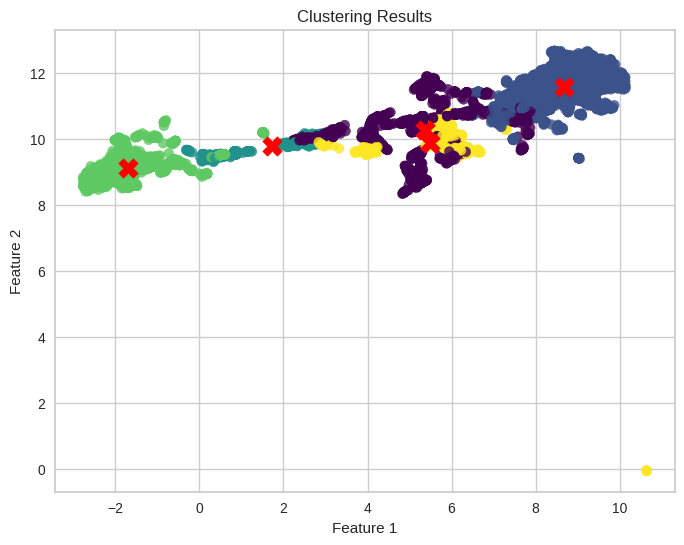

In [64]:
import matplotlib.pyplot as plt
# KMeans clustering with optimal number of clusters
kmeans.fit(docs_)

# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(docs_[:, 0], docs_[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial import distance
# Evaluate clustering using Silhouette Score
silhouette_avg = silhouette_score(docs_, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

# Evaluate clustering using Sum of Squared Errors (SSE)
sse = np.sum((docs_ - kmeans.cluster_centers_[kmeans.labels_]) ** 2)
print(f'SSE: {sse}')

# Evaluate clustering using Davies-Bouldin Index
db_index = davies_bouldin_score(docs_, kmeans.labels_)
print(f'Davies-Bouldin Index: {db_index}')

# Evaluate clustering using Calinski-Harabasz Index (Chi)
calinski_harabasz_index = calinski_harabasz_score(docs_, kmeans.labels_)
print(f'Calinski-Harabasz Index: {calinski_harabasz_index}')

# Dunn Index
def dunn_index(X, labels):
    min_inter_cluster_distance = np.inf
    max_intra_cluster_diameter = -np.inf
    for i in np.unique(labels):
        cluster_points = X[labels == i]
        max_intra_cluster_diameter = max(max_intra_cluster_diameter, np.max(distance.pdist(cluster_points)))
        for j in np.unique(labels):
            if i != j:
                other_cluster_points = X[labels == j]
                min_inter_cluster_distance = min(min_inter_cluster_distance, np.min(distance.cdist(cluster_points, other_cluster_points)))
    dunn = min_inter_cluster_distance / max_intra_cluster_diameter
    return dunn

dunn = dunn_index(docs_, kmeans.labels_)
print(f'Dunn Index: {dunn}')

Silhouette Score: 0.5598738789558411
SSE: 70440.828125
Davies-Bouldin Index: 0.8670767425892825
Calinski-Harabasz Index: 19830.283748624606
Dunn Index: 0.0009528838403492209


In [15]:
from bertopic import BERTopic

topic_model = BERTopic(embedding_model=None, umap_model=None, hdbscan_model=kmeans)
topics, _ = topic_model.fit_transform(docs, docs_)

In [16]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,5181,0_ganjar_prabowo_imin_anies,"[ganjar, prabowo, imin, anies, ketua, cak, pdi...",[ketum partai gerindra prabowo menyebut rencan...
1,1,2675,1_presiden_jokowi_indonesia_nomor,"[presiden, jokowi, indonesia, nomor, urut, gan...",[pasangan calon presiden calon wakil presiden ...
2,2,2510,2_politik_survei_demokrat_partai,"[politik, survei, demokrat, partai, prabowo, k...",[lsn merilis hasil survei terkait elektabilita...
3,3,2348,3_2024_pemilu_pilpres_kpu,"[2024, pemilu, pilpres, kpu, suara, prabowo, g...",[kegiatan pencoblosan pemilu 2024 tanggal 14 f...
4,4,2305,4_debat_gibran_nomor_cawapres,"[debat, gibran, nomor, cawapres, urut, rakabum...",[debat cawapres digelar tkn materi debat cawap...


In [17]:
topic_info = topic_model.get_topic_info()
df = pd.DataFrame(topic_info)
df.to_csv("topic_info_all.csv",index=False)

In [18]:
topic_model.get_topic_info()[:10]

,Topic,Count,Name,Representation,Representative_Docs
0,0,5181,0_ganjar_prabowo_imin_anies,"[ganjar, prabowo, imin, anies, ketua, cak, pdi...",[ketum partai gerindra prabowo menyebut rencan...
1,1,2675,1_presiden_jokowi_indonesia_nomor,"[presiden, jokowi, indonesia, nomor, urut, gan...",[pasangan calon presiden calon wakil presiden ...
2,2,2510,2_politik_survei_demokrat_partai,"[politik, survei, demokrat, partai, prabowo, k...",[lsn merilis hasil survei terkait elektabilita...
3,3,2348,3_2024_pemilu_pilpres_kpu,"[2024, pemilu, pilpres, kpu, suara, prabowo, g...",[kegiatan pencoblosan pemilu 2024 tanggal 14 f...
4,4,2305,4_debat_gibran_nomor_cawapres,"[debat, gibran, nomor, cawapres, urut, rakabum...",[debat cawapres digelar tkn materi debat cawap...


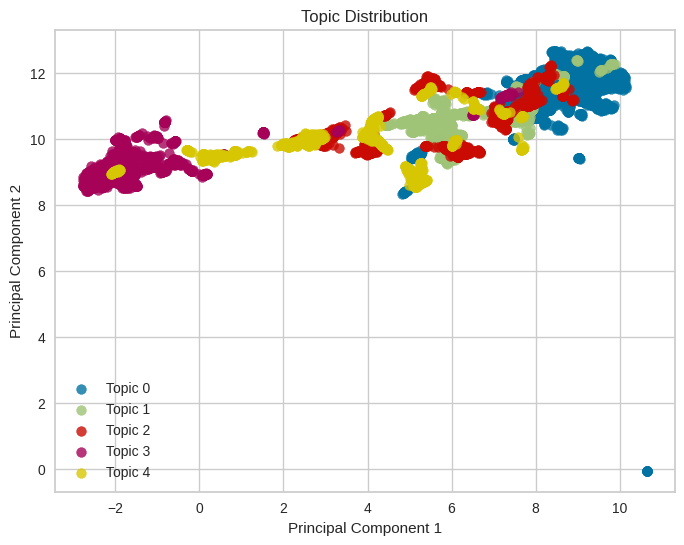

In [19]:
plt.figure(figsize=(8, 6))
for topic in np.unique(topics):
    plt.scatter(docs_[topics == topic, 0], docs_[topics == topic, 1], label=f"Topic {topic}", s=50, alpha=0.8)
plt.title('Topic Distribution')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [20]:
silhouette_avg = silhouette_score(docs_, topics)
print(f'Silhouette Score: {silhouette_avg}')

# Evaluate clustering using Sum of Squared Errors (SSE)
sse = np.sum((docs_ - kmeans.cluster_centers_[topics]) ** 2)
print(f'SSE: {sse}')

# Evaluate clustering using Davies-Bouldin Index
db_index = davies_bouldin_score(docs_, topics)
print(f'Davies-Bouldin Index: {db_index}')

# Evaluate clustering using Calinski-Harabasz Index (Chi)
calinski_harabasz_index = calinski_harabasz_score(docs_, topics)
print(f'Calinski-Harabasz Index: {calinski_harabasz_index}')

# Dunn Index
def dunn_index(X, labels):
    min_inter_cluster_distance = np.inf
    max_intra_cluster_diameter = -np.inf
    for i in np.unique(labels):
        cluster_points = X[labels == i]
        max_intra_cluster_diameter = max(max_intra_cluster_diameter, np.max(distance.pdist(cluster_points)))
        for j in np.unique(labels):
            if i != j:
                other_cluster_points = X[labels == j]
                min_inter_cluster_distance = min(min_inter_cluster_distance, np.min(distance.cdist(cluster_points, other_cluster_points)))
    dunn = min_inter_cluster_distance / max_intra_cluster_diameter
    return dunn

dunn = dunn_index(docs_, topics)
print(f'Dunn Index: {dunn}')

Silhouette Score: 0.40810519456863403
SSE: 2457000.25
Davies-Bouldin Index: 1.4885441839348696
Calinski-Harabasz Index: 9300.655395870583
Dunn Index: 0.006408414553901326


In [38]:
unique_topics = np.unique(topics)
unique_topics

array([0, 1, 2, 3, 4])

In [71]:
def evaluate_per_topic(embeddings, topics, topic_id):
    topic_embeddings = embeddings[topics == topic_id]
    if len(topic_embeddings) < 2:
        return None

    # silhouette_avg = silhouette_score(topic_embeddings, [topic_id] * len(topic_embeddings))

    centroid = np.mean(topic_embeddings, axis=0)
    sse_val = np.sum((topic_embeddings - centroid) ** 2)

    db_index = davies_bouldin_score(topic_embeddings, [topic_id] * len(topic_embeddings))

    def dunn_index(X, labels):
        min_inter_cluster_distance = np.inf
        max_intra_cluster_diameter = -np.inf
        for i in np.unique(labels):
            cluster_points = X[labels == i]
            if len(cluster_points) > 1:
                max_intra_cluster_diameter = max(max_intra_cluster_diameter, np.max(distance.pdist(cluster_points)))
        dunn = min_inter_cluster_distance / max_intra_cluster_diameter
        return dunn

    dunn = dunn_index(topic_embeddings, [topic_id] * len(topic_embeddings))

    return {
        # "Silhouette Score": silhouette_avg,
        "SSE": sse_val,
        "Dunn Index": dunn
    }

for topic_id in unique_topics:
    print(topic_id)
    metrics = evaluate_per_topic(docs_, topics, topic_id)
    if metrics:
        print(f"Metrics for Topic {topic_id}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value}")
    else:
        print(f"Topic {topic_id} has too few samples to evaluate.")

0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [49]:
topic_info = topic_model.get_topic_info()[:10]
df = pd.DataFrame(topic_info)
df.to_csv("topic_info_top_10.csv",index=False)

In [50]:
topic_model.get_topic(0)

[('ganjar', 0.041950577034999915),
 ('prabowo', 0.04173650108448778),
 ('imin', 0.03721675683527497),
 ('anies', 0.03676094803702539),
 ('ketua', 0.03435886112259909),
 ('cak', 0.03347153480434085),
 ('pdip', 0.031235602103115098),
 ('gibran', 0.029430311540046192),
 ('mahfud', 0.02537904427422089),
 ('menyebut', 0.025265565659532148)]

In [51]:
topic_model.visualize_topics()

In [52]:
topic_model.visualize_hierarchy()

In [53]:
topic_model.visualize_barchart()

In [54]:
topic_model.visualize_heatmap()

In [55]:
topic_model.visualize_term_rank()

# Nilai Koherensi

In [56]:
from os import path
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

topics_info = topic_model.get_topics()
def calculate_coherence(topics_info, docs):
    coherence_values = []
    for topic_id in topics_info:
        topic_words = topics_info[topic_id]
        topic_string = ' '.join([str(word) for word in topic_words])
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(docs)
        topic_vectors = vectorizer.transform([topic_string])
        similarity_matrix = cosine_similarity(X, topic_vectors)
        coherence = similarity_matrix.mean()
        coherence_values.append(coherence)
    return coherence_values
coherence_values = calculate_coherence(topics_info, docs)

name_topic_info = pd.read_csv('topic_info_all.csv')
data = {"ID Topic": [f"{i}" for i in range(len(coherence_values))],
        "Koherensi": coherence_values
        }
df = pd.DataFrame(data)
df.to_csv('nilai_topic_koherensi.csv', index=False)

topic_info_all =  pd.read_csv("topic_info_all.csv")
nilai_topic_koherensi = pd.read_csv("nilai_topic_koherensi.csv")

merged_df = pd.merge(topic_info_all, nilai_topic_koherensi, left_on ='Topic', right_on='ID Topic',how='left')

merged_df.drop(columns=['ID Topic'], inplace=True)
merged_df.to_csv('topic_info_all_koherensi.csv', index=False)

if os.path.exists("nilai_topic_koherensi.csv") :
  os.remove("nilai_topic_koherensi.csv")

topic_info_all_koherensi =  pd.read_csv("topic_info_all_koherensi.csv")
topic_info_all_koherensi[:10]


,Topic,Count,Name,Representation,Representative_Docs,Koherensi
0,0,5181,0_ganjar_prabowo_imin_anies,"['ganjar', 'prabowo', 'imin', 'anies', 'ketua'...",['ketum partai gerindra prabowo menyebut renca...,0.101277
1,1,2675,1_presiden_jokowi_indonesia_nomor,"['presiden', 'jokowi', 'indonesia', 'nomor', '...",['pasangan calon presiden calon wakil presiden...,0.077433
2,2,2510,2_politik_survei_demokrat_partai,"['politik', 'survei', 'demokrat', 'partai', 'p...",['lsn merilis hasil survei terkait elektabilit...,0.065047
3,3,2348,3_2024_pemilu_pilpres_kpu,"['2024', 'pemilu', 'pilpres', 'kpu', 'suara', ...",['kegiatan pencoblosan pemilu 2024 tanggal 14 ...,0.100189
4,4,2305,4_debat_gibran_nomor_cawapres,"['debat', 'gibran', 'nomor', 'cawapres', 'urut...",['debat cawapres digelar tkn materi debat cawa...,0.088987


# World cloud

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(train['description_clean'])

In [58]:
word_scores = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out() ).mean()
top_words = word_scores.nlargest(30)
top_words

prabowo          0.027059
ganjar           0.023700
2024             0.023587
gibran           0.022029
anies            0.020065
presiden         0.018016
cawapres         0.017277
imin             0.017161
pemilu           0.016646
jokowi           0.016632
nomor            0.016423
pilpres          0.016079
capres           0.015908
urut             0.015656
debat            0.015594
ketua            0.015204
partai           0.015159
cak              0.015023
pdip             0.014623
subianto         0.014531
mahfud           0.014423
rakabuming       0.014171
pranowo          0.013475
prabowogibran    0.012858
kpu              0.012824
menyebut         0.012700
indonesia        0.012147
baswedan         0.011288
kampanye         0.011153
md               0.011151
dtype: float64

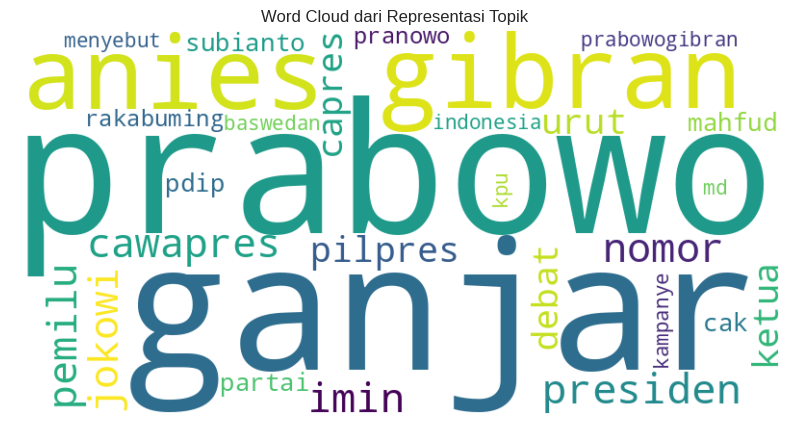

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_representations = ' '.join(top_words.index)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_representations)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Representasi Topik')
plt.show()


In [88]:
topic_model.get_document_info(docs)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,cak imin cawapres anies dibahas rapat tim 8 de...,3,3_2024_pemilu_pilpres_kpu,"[2024, pemilu, pilpres, kpu, suara, prabowo, g...",[kegiatan pencoblosan pemilu 2024 tanggal 14 f...,2024 - pemilu - pilpres - kpu - suara - prabow...,False
1,mantan anggota tim 8 kpp iftitah sulaiman part...,2,2_politik_survei_demokrat_partai,"[politik, survei, demokrat, partai, prabowo, k...",[lsn merilis hasil survei terkait elektabilita...,politik - survei - demokrat - partai - prabowo...,False
2,ppp merespons sby menyebut menteri aktif menga...,0,0_ganjar_prabowo_imin_anies,"[ganjar, prabowo, imin, anies, ketua, cak, pdi...",[ketum partai gerindra prabowo menyebut rencan...,ganjar - prabowo - imin - anies - ketua - cak ...,False
3,zulhas menyebut cak imin seakanakan belok lamp...,0,0_ganjar_prabowo_imin_anies,"[ganjar, prabowo, imin, anies, ketua, cak, pdi...",[ketum partai gerindra prabowo menyebut rencan...,ganjar - prabowo - imin - anies - ketua - cak ...,False
4,gerindra bicara peluang demokrat merapat koali...,2,2_politik_survei_demokrat_partai,"[politik, survei, demokrat, partai, prabowo, k...",[lsn merilis hasil survei terkait elektabilita...,politik - survei - demokrat - partai - prabowo...,False
...,...,...,...,...,...,...,...
15014,cak imin menyoroti proses pencoblosan negeri c...,0,0_ganjar_prabowo_imin_anies,"[ganjar, prabowo, imin, anies, ketua, cak, pdi...",[ketum partai gerindra prabowo menyebut rencan...,ganjar - prabowo - imin - anies - ketua - cak ...,False
15015,pelanggaran formulir c6 pemberitahuan pemungut...,1,1_presiden_jokowi_indonesia_nomor,"[presiden, jokowi, indonesia, nomor, urut, gan...",[pasangan calon presiden calon wakil presiden ...,presiden - jokowi - indonesia - nomor - urut -...,False
15016,samawi menggelar doa kelancaran pemilu 2024 sa...,3,3_2024_pemilu_pilpres_kpu,"[2024, pemilu, pilpres, kpu, suara, prabowo, g...",[kegiatan pencoblosan pemilu 2024 tanggal 14 f...,2024 - pemilu - pilpres - kpu - suara - prabow...,False
15017,kpu ri menerbitkan keputusan pencoblosan pania...,3,3_2024_pemilu_pilpres_kpu,"[2024, pemilu, pilpres, kpu, suara, prabowo, g...",[kegiatan pencoblosan pemilu 2024 tanggal 14 f...,2024 - pemilu - pilpres - kpu - suara - prabow...,False
